In [1]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv


In [2]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv("covid_19_clean_complete.csv", delimiter=",",parse_dates=['Date'])
df.groupby(['Country/Region']).sum()
a = df['Country/Region']
print(a)
df.groupby(['Confirmed']).sum()

b = df['Confirmed']
print(b)
# date = [elem for elem in df['Date']]
# values = [elem for elem in df['Confirmed']]
# plt.xticks(range(0,len(date)),rotation=45)
# plt.plot(country, values)
df = pd.read_csv("covid_19_clean_complete.csv")
df.tail(5)
c= df['Date']
print(c)


#df['Date'] = pd.to_datetime(df['Date'])
#df['Dates'] = df['Date'].apply(lambda x:x.strftime('%B'))
#p = df.groupby('Dates')
#print(p)

df.head(10)

0                  Afghanistan
1                      Albania
2                      Algeria
3                      Andorra
4                       Angola
                 ...          
32060    Sao Tome and Principe
32061                    Yemen
32062                  Comoros
32063               Tajikistan
32064                  Lesotho
Name: Country/Region, Length: 32065, dtype: object
0           0
1           0
2           0
3           0
4           0
         ... 
32060     251
32061     197
32062      34
32063    2350
32064       1
Name: Confirmed, Length: 32065, dtype: int64
0        1/22/20
1        1/22/20
2        1/22/20
3        1/22/20
4        1/22/20
          ...   
32060    5/21/20
32061    5/21/20
32062    5/21/20
32063    5/21/20
32064    5/21/20
Name: Date, Length: 32065, dtype: object


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0,0,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0,0,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0,0,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0,0,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0,0,0
5,NaN,Antigua and Barbuda,17.0608,-61.7964,1/22/20,0,0,0
6,NaN,Argentina,-38.4161,-63.6167,1/22/20,0,0,0
7,NaN,Armenia,40.0691,45.0382,1/22/20,0,0,0
8,Australian Capital Territory,Australia,-35.4735,149.0124,1/22/20,0,0,0
9,New South Wales,Australia,-33.8688,151.2093,1/22/20,0,0,0


In [44]:
sns.set(palette = 'Set1',style='darkgrid')
#Function for making a time serie on a designated country and plotting the rolled mean and standard 
def roll(country,case='Confirmed'):
    ts=df.loc[(df['Country/Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['Confirmed']>=10)])
    ts=ts[-a:]
    return (ts.rolling(window=4,center=False).mean().dropna())


def rollPlot(country, case='Confirmed'):
    ts=df.loc[(df['Country/Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['Confirmed']>=10)])
    ts=ts[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(ts[case], label='Confirmed')
    plt.plot(ts.rolling(window=7,center=False).std(),label='Rolling std')
    #plt.plot('Confirmed', label='First Line')
    plt.legend()
    plt.title('Cases distribution in %s with rolling mean and standard' %country)
    plt.xticks([])

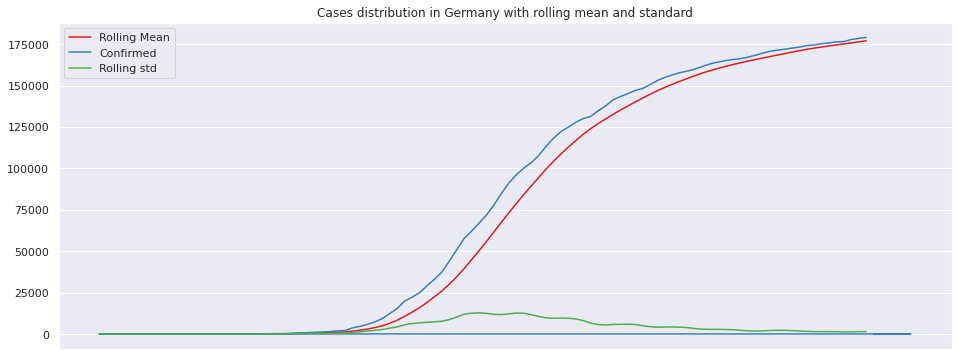

In [45]:
tsC1=roll('Germany')
rollPlot('Germany')

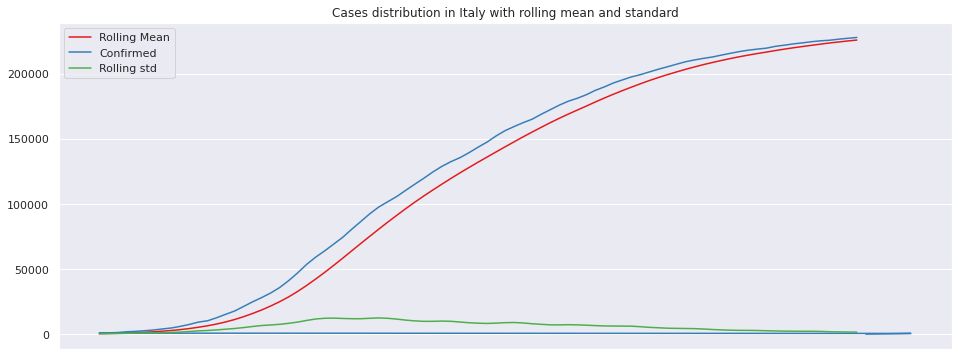

In [46]:
tsC2=roll('Italy')
rollPlot('Italy')

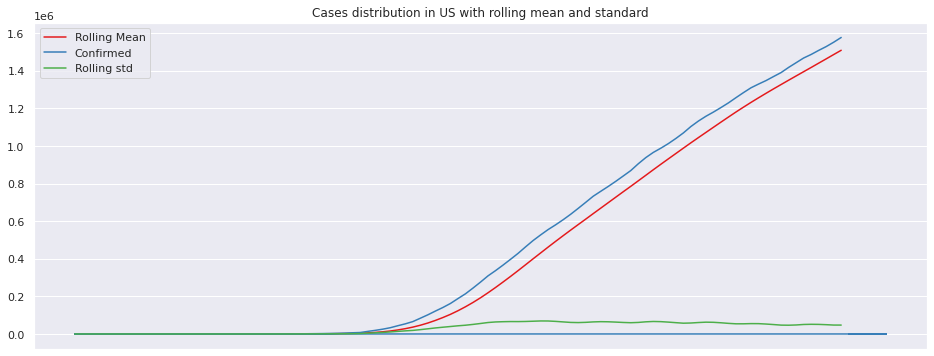

In [47]:
tsC3=roll('US')
rollPlot('US')

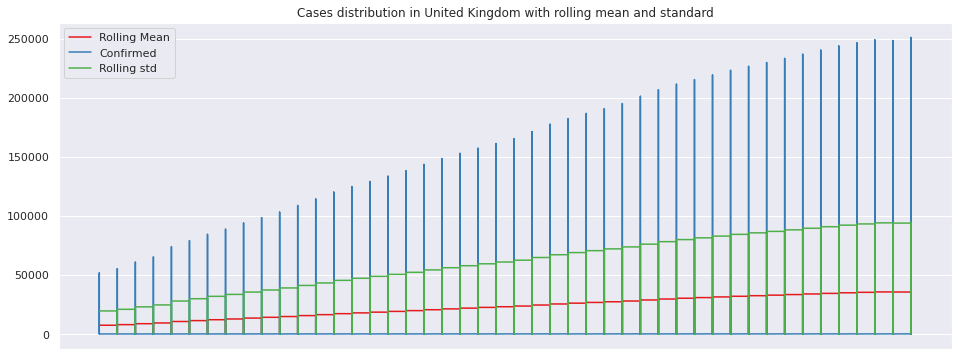

In [48]:
tsC4=roll('United Kingdom')
rollPlot('United Kingdom')

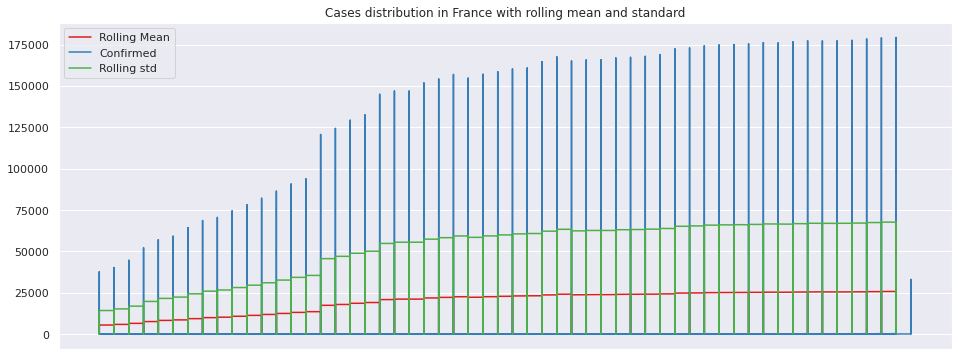

In [49]:
tsC5=roll('France')
rollPlot('France')

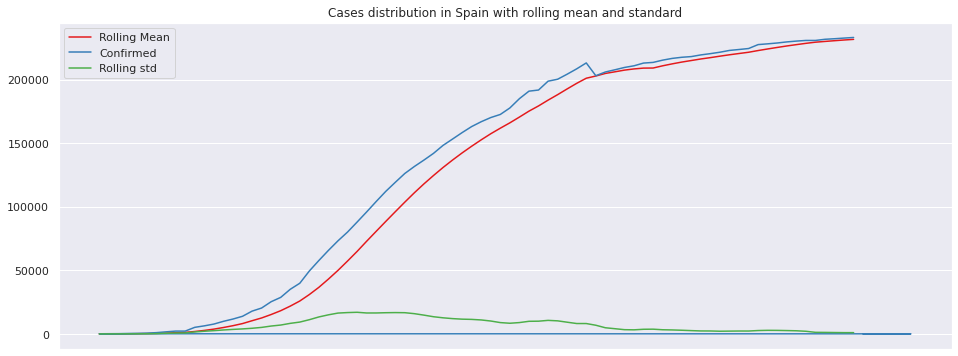

In [50]:
tsC6=roll('Spain')
rollPlot('Spain')

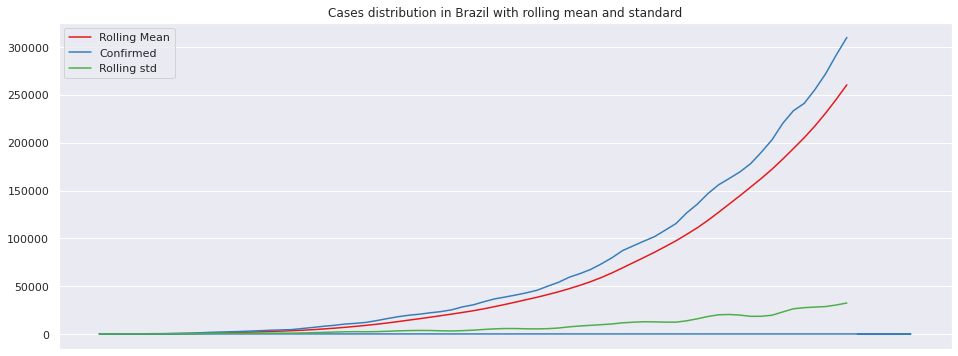

In [51]:
tsC7=roll('Brazil')
rollPlot('Brazil')

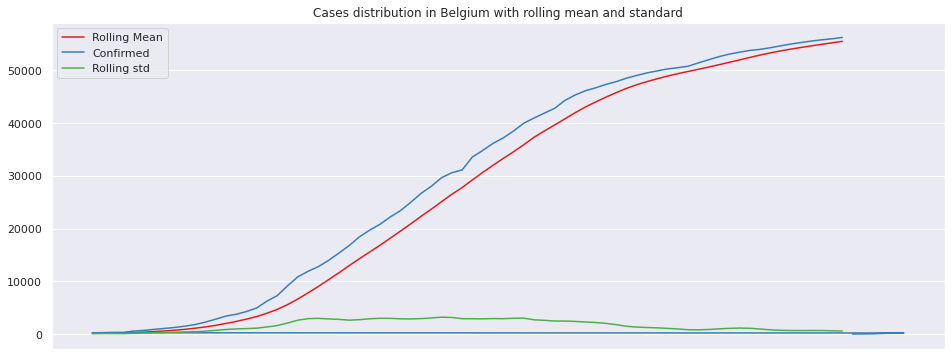

In [52]:
tsC8=roll('Belgium')
rollPlot('Belgium')

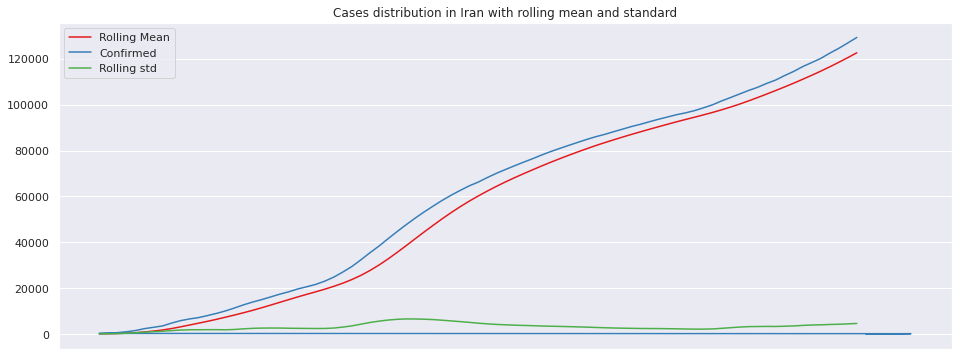

In [54]:
tsC9=roll('Iran')
rollPlot('Iran')

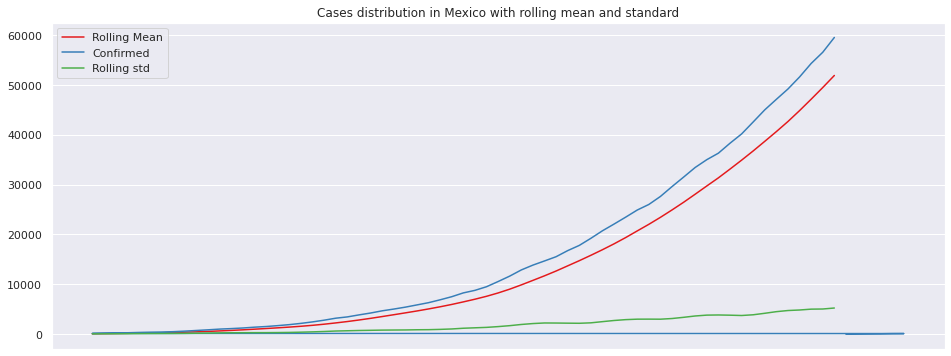

In [55]:
tsC10=roll('Mexico')
rollPlot('Mexico')

In [60]:

df = pd.read_csv("covid_19_clean_complete.csv", delimiter=",")
train_data, test_data= np.split(df, [int(.75 *len(df))])

In [61]:
#test['Date'] = pd.to_datetime(test['Date'])
#train['Date'] = pd.to_datetime(train['Date'])
train_data = train_data.set_index(['Date'])
test_data = test_data.set_index(['Date'])

#data['Date'] = pd.to_datetime(data['Date'])

#data.set_index(['Date', 'month'], inplace=True)

In [62]:
def create_features(df,label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['Date'] = df.index
    #df['hour'] = df['Dates'].dt.hour
    df['dayofweek'] = df['Date'].str.replace('dayofweek','')
    #df['quarter'] = df['Dates'].dt.quarter
    df['month'] = df['Date'].str.replace('month','')
    df['year'] = df['Date'].str.replace('year','')
    df['dayofyear'] = df['Date'].str.replace('dayofyear','')
    df['dayofmonth'] = df['Date'].str.replace('dayofmonth','')
    df['weekofyear'] = df['Date'].str.replace('weekofyear','')
    
    X = df[['dayofweek','month','year',
           'dayofyear','dayofmonth','weekofyear']]
   
    return X

In [63]:
train_features=pd.DataFrame(create_features(train_data))
test_features=pd.DataFrame(create_features(test_data))
features_and_target_train = pd.concat([train_data,train_features], axis=1)
features_and_target_test = pd.concat([test_data,test_features], axis=1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def FunLabelEncoder(df):
    for c in df.columns:
        if df.dtypes[c] == object:
            le.fit(df[c].astype(str))
            df[c] = le.transform(df[c].astype(str))
    return df
features_and_target_train= FunLabelEncoder(features_and_target_train)

In [64]:
x_train= features_and_target_train[['Country/Region','month' , 'weekofyear']]
y1 = features_and_target_train[['Deaths']]
x_test = features_and_target_test[['Country/Region', 'month' , 'weekofyear']]

In [65]:
from statsmodels.tools.eval_measures import rmse, meanabs
from sklearn.metrics import mean_squared_error,mean_absolute_error

Predicted values : [174204.63193797 174771.23684144 175245.40608883 175744.5835331
 176154.2579755  176426.23647552 176534.26217005]
                             ARIMA Model Results                              
Dep. Variable:           D2.Confirmed   No. Observations:                   98
Model:                 ARIMA(5, 2, 5)   Log Likelihood                -632.827
Method:                       css-mle   S.D. of innovations            140.902
Date:                Mon, 13 Jul 2020   AIC                           1289.654
Time:                        21:45:56   BIC                           1320.674
Sample:                    02-07-2020   HQIC                          1302.201
                         - 05-14-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.3952     76.020     -0.032      0.97

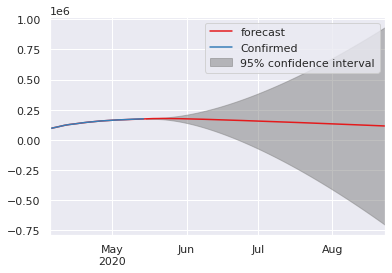

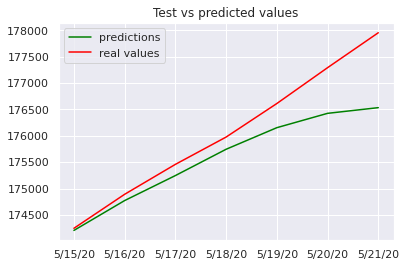

In [66]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.94)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC1)
prediction=arima(train,test)

Predicted values : [225609.97184085 226164.21679873 226685.6677132 ]
                             ARIMA Model Results                              
Dep. Variable:           D2.Confirmed   No. Observations:                   83
Model:                 ARIMA(3, 2, 5)   Log Likelihood                -510.793
Method:                       css-mle   S.D. of innovations            103.686
Date:                Mon, 13 Jul 2020   AIC                           1041.586
Time:                        21:47:16   BIC                           1065.774
Sample:                    02-26-2020   HQIC                          1051.303
                         - 05-18-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.3848     41.056      0.131      0.896     -75.084      85.854
ar.L1.D2.Confirmed     1.5300      0.1

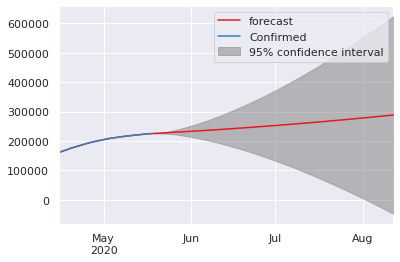

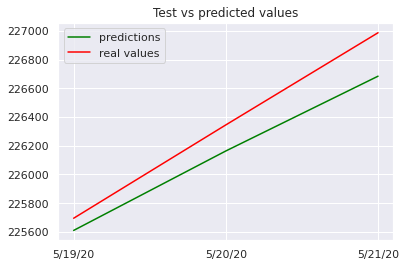

In [67]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.97)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC2)
prediction=arima(train,test)

Predicted values : [1519590.56774124 1542901.15981817]
                             ARIMA Model Results                              
Dep. Variable:           D2.Confirmed   No. Observations:                  102
Model:                 ARIMA(5, 2, 3)   Log Likelihood                -776.933
Method:                       css-mle   S.D. of innovations            476.873
Date:                Mon, 13 Jul 2020   AIC                           1573.866
Time:                        21:48:30   BIC                           1600.116
Sample:                    02-08-2020   HQIC                          1584.495
                         - 05-19-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                199.7763    316.316      0.632      0.529    -420.191     819.743
ar.L1.D2.Confirmed     1.3627      0.131     10.427 

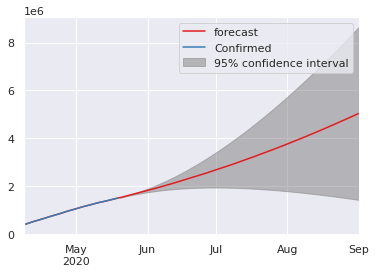

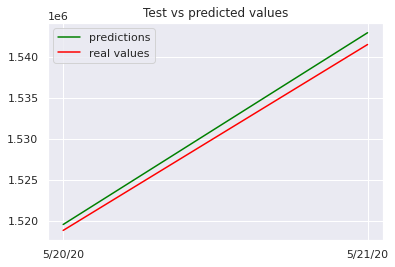

In [68]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.99)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC3)
prediction=arima(train,test)

Predicted values : [ -4269.88495883 -11772.32682688  20410.93234021  14188.68362148
  16430.72723591  33312.61992791   8730.08564676  13341.7037351
  17364.43779824  -3453.81788516  15083.53262215  13499.14957435
   3484.45930974  24739.52538879  11512.39826615   8998.65591497
  23459.13517488   3918.50989737  12034.32233874  18930.22135233
   1944.64655567  18392.21644978  15338.07177063   4511.26638694
  22152.87682739   9698.08824577   7878.65944777  21665.33496165
   5003.64701975  12935.20466313  19161.65604608   3674.02216281
  18028.47459793  14806.14507419   4937.71789097  20776.25922879
   9712.41966624   8377.55000178  20880.2903188    5979.63210978]
                              ARMA Model Results                              
Dep. Variable:              Confirmed   No. Observations:                  459
Model:                     ARMA(5, 2)   Log Likelihood               -4891.415
Method:                       css-mle   S.D. of innovations          10127.064
Date:          

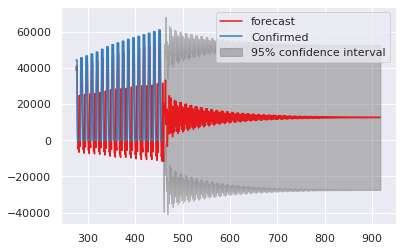

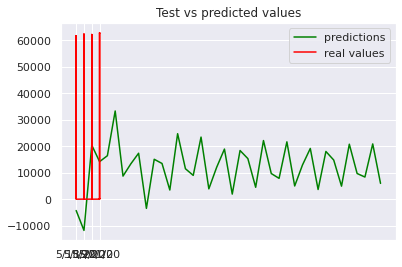

In [69]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.92)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC4)
prediction=arima(train,test)

Predicted values : [ 8304.34368052 11959.96291066 39646.4510456  33909.76461546
 29678.52339679 34577.29331808  8655.8459669   6268.3139916
  7713.52015984 -5936.29589118 12916.51643375 18565.29286967
 16358.4078835  35509.03015186 25462.55475047 19694.03803478
 25777.2845195   5964.16061042  8564.63107231 13901.39924897
  3079.72911425 19568.98123734 21979.45552584 16197.87206161
 30634.10991333 19823.75847397 14802.2096295  22437.55356859
  7026.43984007 11909.96984591 18323.63746711  8301.87639473
 22063.47942502 22249.18262485 14865.13063029 26895.03618615
 16866.81580178]
                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                  569
Model:                 ARIMA(5, 1, 4)   Log Likelihood               -5850.780
Method:                       css-mle   S.D. of innovations           6933.375
Date:                Mon, 13 Jul 2020   AIC                          11723.559
Time:                

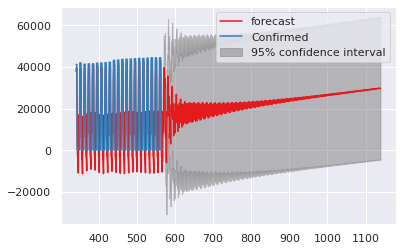

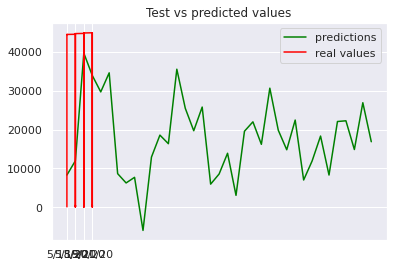

In [70]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.94)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC5)
prediction=arima(train,test)

Predicted values : [230575.40195638 231229.93630958 232015.96927722 232828.66327808
 233651.02327142]
                             ARIMA Model Results                              
Dep. Variable:           D2.Confirmed   No. Observations:                   76
Model:                 ARIMA(0, 2, 4)   Log Likelihood                -588.033
Method:                       css-mle   S.D. of innovations            530.684
Date:                Mon, 13 Jul 2020   AIC                           1188.066
Time:                        21:51:26   BIC                           1202.051
Sample:                    03-02-2020   HQIC                          1193.655
                         - 05-16-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  9.6660     84.559      0.114      0.909    -156.066     175.398
ma.L1

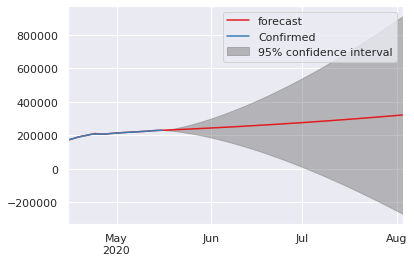

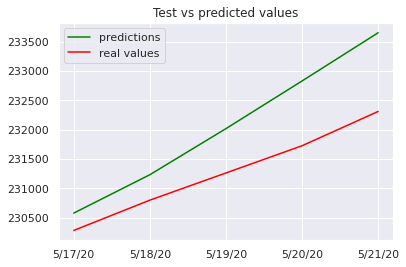

In [71]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.95)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC6)
prediction=arima(train,test)

Predicted values : [281739.75344017]
                             ARIMA Model Results                              
Dep. Variable:           D2.Confirmed   No. Observations:                   71
Model:                 ARIMA(4, 2, 2)   Log Likelihood                -525.132
Method:                       css-mle   S.D. of innovations            371.545
Date:                Mon, 13 Jul 2020   AIC                           1066.265
Time:                        21:52:01   BIC                           1084.366
Sample:                    03-11-2020   HQIC                          1073.463
                         - 05-20-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                216.5020     57.594      3.759      0.000     103.620     329.384
ar.L1.D2.Confirmed     0.6168      0.127      4.872      0.000       0

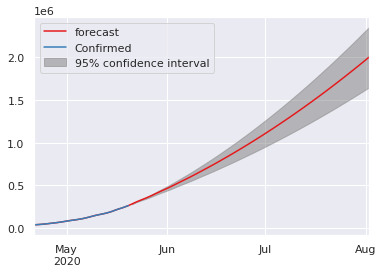

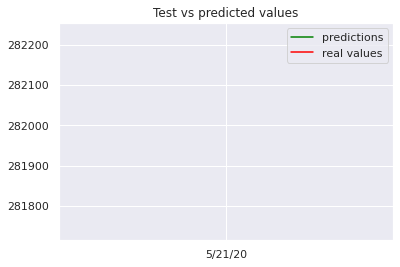

In [72]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.99)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC7)
prediction=arima(train,test)

Predicted values : [54821.74408532 55181.64771815 55538.14513208 55879.06370274
 56206.86111609]
                             ARIMA Model Results                              
Dep. Variable:           D2.Confirmed   No. Observations:                   70
Model:                 ARIMA(1, 2, 5)   Log Likelihood                -409.160
Method:                       css-mle   S.D. of innovations             78.382
Date:                Mon, 13 Jul 2020   AIC                            834.321
Time:                        21:52:56   BIC                            852.309
Sample:                    03-08-2020   HQIC                           841.466
                         - 05-16-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.3445     22.863      0.146      0.884     -41.466      48.155
ar.L1.D2.C

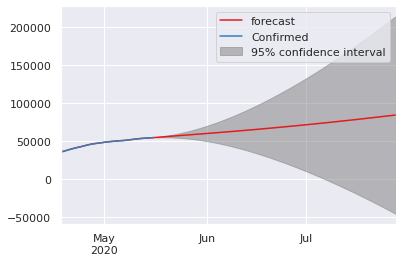

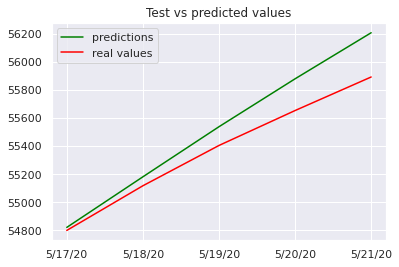

In [73]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.94)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC8)
prediction=arima(train,test)

Predicted values : [115713.9753219  117833.63420787 120108.82486736 122447.53819215
 124837.57212956 127288.69711706]
                             ARIMA Model Results                              
Dep. Variable:           D2.Confirmed   No. Observations:                   80
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -436.382
Method:                       css-mle   S.D. of innovations             54.456
Date:                Mon, 13 Jul 2020   AIC                            886.764
Time:                        21:53:33   BIC                            903.438
Sample:                    02-26-2020   HQIC                           893.449
                         - 05-15-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 26.5235     26.608      0.997      0.322     -25.628  

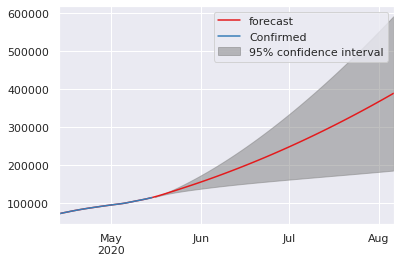

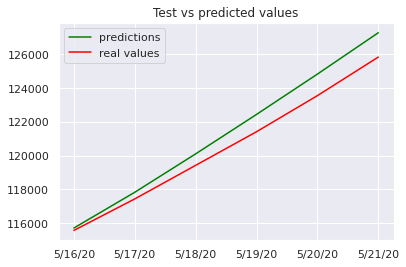

In [74]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.94)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC9)
prediction=arima(train,test)

Predicted values : [45963.0592628  48100.26601567 50097.10244859 52192.09896058
 54417.96504331]
                             ARIMA Model Results                              
Dep. Variable:           D2.Confirmed   No. Observations:                   61
Model:                 ARIMA(4, 2, 3)   Log Likelihood                -310.026
Method:                       css-mle   S.D. of innovations             35.517
Date:                Mon, 13 Jul 2020   AIC                            638.052
Time:                        21:54:02   BIC                            657.050
Sample:                    03-17-2020   HQIC                           645.497
                         - 05-16-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 33.9491      6.087      5.577      0.000      22.019      45.879
ar.L1.D2.C

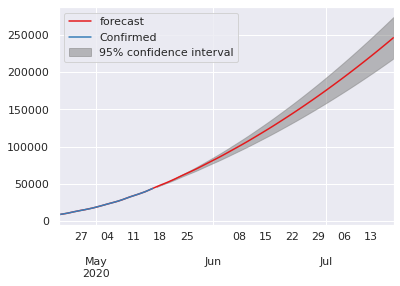

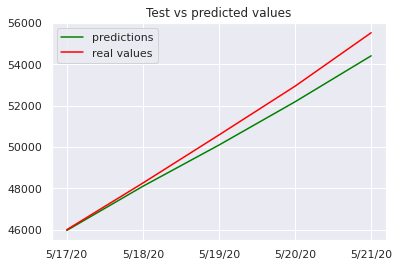

In [75]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.94)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC10)
prediction=arima(train,test)

In [ ]:
#Checking for similarity(Trend) between Germany and Italy in Death cases using number of predicted values from model result

In [ ]:

from scipy.special import rel_entr
# defining distributions
Germany = [7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069]
Italy = [31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576]
# calculating (Germany || Italy)
kl_Germany_Italy = rel_entr(Germany, Italy)
print('KL(Germany || Italy): %.3f nats' % sum(kl_Germany_Italy))
# calculating (Italy || Germany)
kl_Italy_Germany = rel_entr(Italy,Germany)
print('KL(Italy || Germany): %.3f nats' % sum(kl_Italy_Germany))

KL(Germany || Italy): -67479.016 nats
KL(Italy || Germany): 267337.231 nats


In [ ]:
#Hence,Kl divergence satisfies the condition that KL(Germany || Italy)!=KL(Italy || Germany)


In [ ]:

from scipy.spatial.distance import jensenshannon
from numpy import asarray
# defining distributions
Germany = asarray([7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069])
Italy = asarray([31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576])
# calculating (Germany || Italy)
JS_Germany_Italy = jensenshannon(Germany, Italy,base=2)
print('JS(Germany || Italy): %.3f nats' % JS_Germany_Italy)
# calculating (Italy || Germany)
JS_Italy_Germany = jensenshannon(Italy,Germany,base=2)
print('JS(Italy || Germany): %.3f nats' % JS_Italy_Germany)

JS(Germany || Italy): 0.001 nats
JS(Italy || Germany): 0.001 nats


In [ ]:
#Hence,JS divergence satisfies the condition that JS(Germany || Italy)==JS(Italy || Germany)


In [ ]:
from scipy import stats
stats.spearmanr([7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069], [31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576])

np.random.seed(7972)
x2n = np.random.randn(100, 2)
y2n = np.random.randn(100, 2)
stats.spearmanr(x2n)

SpearmanrResult(correlation=0.1438943894389439, pvalue=0.15320623761722527)

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#df = pd.read_csv('synchrony_sample.csv')
overall_pearson_r = df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943
#df.loc[(df['Country/Region']==country)]
r, p = stats.pearsonr(df.loc[(Country/Region['Germany'])].dropna(), df.loc[(df['Country/Region(Italy)'])].dropna())
#r, p = stats.pearsonr(df.dropna()['Confirmed'], df.dropna()['Recovered'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
df.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

Pandas computed Pearson r: -0.1282098089914872


NameError: ignored